In [2]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, box
import matplotlib.pyplot as plt
import requests
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time
import pandas as pd
from nltk import edit_distance
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets
from src.models import ModelManager, load_word2vec_model
from src.analogy_tests import (
    run_analogy_test_suite,
    print_test_summary,
    test_analogy,
    explore_nearest_neighbors,
    calculate_vector_arithmetic
)

In [3]:
manager = ModelManager()
model = manager.load_word2vec_google_news()

Loading Word2Vec Google News model...
Model: word2vec-google-news-300
Size: ~1.6GB download, ~3.5GB in memory
This may take a few minutes on first download...
✓ Model loaded successfully!
  Vocabulary size: 3,000,000 words
  Vector dimensions: 300


In [18]:
def analogy_calc(lis):
    """
    lis is a list of lists
    each list in lis is of the form word1, word2, word3, target1, target2 (eg Lyon, French, Belfast, British, Irish)
    it does the vector calculation
    """
    try:
        res_li = []
        for li in lis:
            try:
                word1, word2, word3, target1, target2 = li
                positive = [word2, word3]
                negative = [word1]
                res = calculate_vector_arithmetic(model, positive, negative, topn=1000)
                
                res = pd.DataFrame(res, columns=['word', 'similarity']).reset_index()

                res['word'] = res['word'].str.lower()

                res['edit_distance_target1'] = res['word'].apply(lambda el: edit_distance(el, target1.lower()))
                res['edit_distance_target2'] = res['word'].apply(lambda el: edit_distance(el, target2.lower()))
                # print(res)
                target1_similarity = res[res['edit_distance_target1'] <= 1].set_index('word')['similarity'].max()
                target2_similarity = res[res['edit_distance_target2'] <= 1].set_index('word')['similarity'].max()

                target1_index = res[res['edit_distance_target1'] <= 1].set_index('word')['index'].min()
                target2_index = res[res['edit_distance_target2'] <= 1].set_index('word')['index'].min()
                res_li.append({
                    'list': li,
                    f'{target1}_similarity' : target1_similarity,
                    f'{target2}_similarity' : target2_similarity,
                    f'{target1}_rank' : target1_index,
                    f'{target2}_rank' : target2_index
                })
            except Exception:
                continue
        return res_li
        
    except Exception as e:
        print(f"\nError: {e}")
        import traceback
        traceback.print_exc()
        return 1

In [ ]:
# don't need to run this, geographic data is saved to csv (see next cell)

# # Step 1: Download table from Wikipedia (with user-agent)
# url = "https://en.wikipedia.org/wiki/List_of_settlements_on_the_island_of_Ireland_by_population"
# headers = {"User-Agent": "Mozilla/5.0 (compatible; IrishTownsMapper/1.0; +https://example.com/contact)"}
# r = requests.get(url, headers=headers)
# r.raise_for_status()

# # Step 2: Read table and take top 50
# tables = pd.read_html(r.text)
# df = tables[0].head(50)

# # Clean up column names (optional)
# df.columns = [c.strip() for c in df.columns]

# # Step 3: Set up geocoder
# geolocator = Nominatim(user_agent="IrishTownsMapper/1.0")
# geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)  # be polite!

# # Step 4: Get lat/long for each town
# lats, longs = [], []

# for place in df["Settlement"]:
#     try:
#         location = geocode(f"{place}, Ireland")
#         if location is None:
#             location = geocode(f"{place}, Northern Ireland")
#         if location:
#             lats.append(location.latitude)
#             longs.append(location.longitude)
#         else:
#             lats.append(None)
#             longs.append(None)
#     except Exception as e:
#         print(f"Error geocoding {place}: {e}")
#         lats.append(None)
#         longs.append(None)
#     time.sleep(1)  # extra delay for safety

# df["Latitude"] = lats
# df["Longitude"] = longs

# # Step 5: Save to CSV
# df.to_csv("top50_irish_towns_with_coords.csv", index=False)
# print("Saved top50_irish_towns_with_coords.csv ✅")


In [6]:
df = pd.read_csv("top50_irish_towns_with_coords.csv")
df = df[['Settlement', 'Jurisdiction', 'Latitude', 'Longitude']]
df

,Settlement,Jurisdiction,Latitude,Longitude
0,Dublin,Republic,53.349379,-6.260559
1,Belfast,Northern,54.597580,-5.927710
2,Cork,Republic,51.898514,-8.472642
3,Limerick,Republic,52.661252,-8.630124
4,Galway,Republic,53.274412,-9.049060
5,Derry,Northern,53.400846,-7.251987
6,Newtownabbey,Northern,54.677882,-5.924920
7,Bangor,Northern,54.154855,-9.721193
8,Waterford,Republic,52.261000,-7.111908
9,Lisburn,Northern,53.403256,-8.324792


In [21]:
input_for_analogy_calc = [['Lyon', 'French', el, 'Irish', 'British'] for el in df['Settlement']]

res = pd.DataFrame(analogy_calc(input_for_analogy_calc))

res['Settlement'] = res['list'].map(lambda e: e[2])

res = pd.merge(df, res, on='Settlement')
res.head()

res = res.dropna()

abs_diffs = np.abs(res['Irish_similarity'] - res['British_similarity'])
std = np.std(abs_diffs)

res['irishness'] = (res['Irish_similarity'] - res['British_similarity']) / std

Error: Word not found in vocabulary: "Key 'Greystones-Delgany' not present in vocabulary"
Error: Word not found in vocabulary: "Key 'Laytown–Bettystown–Mornington–Donacarney' not present in vocabulary"


In [22]:
res

,Settlement,Jurisdiction,Latitude,Longitude,list,Irish_similarity,British_similarity,Irish_rank,British_rank,irishness
0,Dublin,Republic,53.349379,-6.260559,"[Lyon, French, Dublin, Irish, British]",0.655825,0.512567,0.0,2.0,2.632061
1,Belfast,Northern,54.597580,-5.927710,"[Lyon, French, Belfast, Irish, British]",0.575745,0.568508,0.0,1.0,0.132963
2,Cork,Republic,51.898514,-8.472642,"[Lyon, French, Cork, Irish, British]",0.637087,0.465244,0.0,36.0,3.157243
3,Limerick,Republic,52.661252,-8.630124,"[Lyon, French, Limerick, Irish, British]",0.635086,0.413726,0.0,236.0,4.067020
4,Galway,Republic,53.274412,-9.049060,"[Lyon, French, Galway, Irish, British]",0.632031,0.427482,0.0,239.0,3.758137
5,Derry,Northern,53.400846,-7.251987,"[Lyon, French, Derry, Irish, British]",0.612516,0.466418,0.0,17.0,2.684225
6,Newtownabbey,Northern,54.677882,-5.924920,"[Lyon, French, Newtownabbey, Irish, British]",0.445092,0.477187,34.0,9.0,-0.589683
7,Bangor,Northern,54.154855,-9.721193,"[Lyon, French, Bangor, Irish, British]",0.392800,0.443844,35.0,4.0,-0.937830
8,Waterford,Republic,52.261000,-7.111908,"[Lyon, French, Waterford, Irish, British]",0.581880,0.388779,0.0,169.0,3.547821
9,Lisburn,Northern,53.403256,-8.324792,"[Lyon, French, Lisburn, Irish, British]",0.489508,0.530877,10.0,2.0,-0.760073


In [8]:
gadm_uk = gpd.read_file("https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_GBR_shp.zip")
gadm_ie = gpd.read_file("https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_IRL_shp.zip")

british_isles = gpd.GeoDataFrame(pd.concat([gadm_uk, gadm_ie], ignore_index=True))

bounds = box(-11, 49.5, -5, 60)
british_isles = british_isles.clip(bounds)

/Users/daxmavy/oxford/fsds25-analogy/.venv/lib/python3.13/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'gadm41_GBR_shp.zip': 'gadm41_GBR_0' (default), 'gadm41_GBR_1', 'gadm41_GBR_2', 'gadm41_GBR_3', 'gadm41_GBR_4'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/daxmavy/oxford/fsds25-analogy/.venv/lib/python3.13/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'gadm41_IRL_shp.zip': 'gadm41_IRL_0' (default), 'gadm41_IRL_1', 'gadm41_IRL_2'. Specify layer parameter to avoid this warning.
  result = read_func(


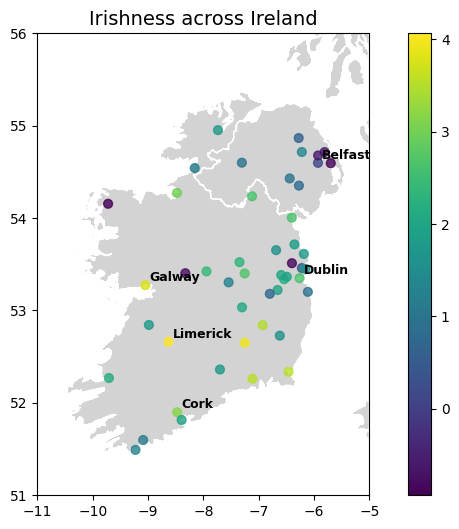

In [10]:
# Create geometry from coordinates
geometry = [Point(xy) for xy in zip(res['Longitude'], res['Latitude'])]
gdf = gpd.GeoDataFrame(res, geometry=geometry, crs="EPSG:4326")

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))
british_isles.plot(ax=ax, color="lightgrey", edgecolor="white")

# Points colored by 'irishness'
gdf.plot(
    ax=ax,
    column="irishness",
    cmap="viridis",
    legend=True,
    markersize=40,
    alpha=0.8
)

ax.set_xlim([-11, -5])
ax.set_ylim([51, 56])
ax.set_title("Irishness across Ireland", fontsize=14)

# --- Annotate top 5 towns ---
for i, row in gdf.head(5).iterrows():
    ax.annotate(
        text=row["Settlement"],         # column containing town name
        xy=(row["Longitude"], row["Latitude"]),
        xytext=(3, 3),                  # small offset in points
        textcoords="offset points",
        fontsize=9,
        fontweight="bold",
        color="black"
        # path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=2, foreground="white")]
    )

plt.show()


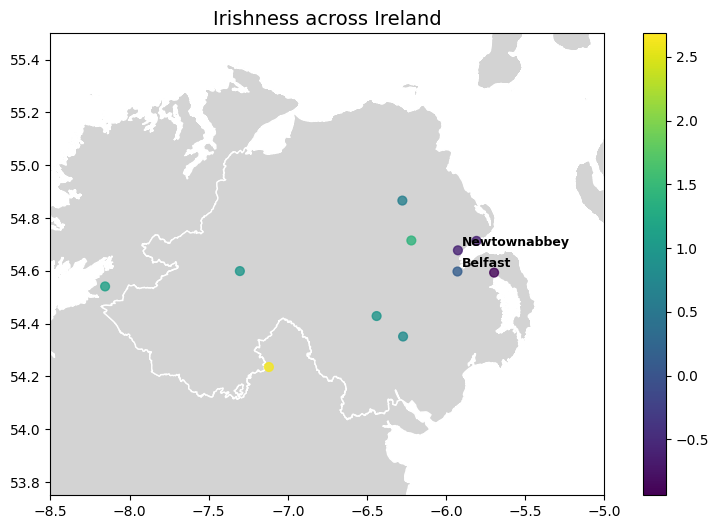

In [11]:
# Create geometry from coordinates
ni_res = res[res['Jurisdiction'] == 'Northern']

geometry = [Point(xy) for xy in zip(ni_res['Longitude'], ni_res['Latitude'])]
gdf = gpd.GeoDataFrame(ni_res, geometry=geometry, crs="EPSG:4326")

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))
british_isles.plot(ax=ax, color="lightgrey", edgecolor="white")

# Points colored by 'irishness'
gdf.plot(
    ax=ax,
    column="irishness",
    cmap="viridis",
    legend=True,
    markersize=40,
    alpha=0.8
)

ax.set_xlim([-8.5, -5])
ax.set_ylim([53.75, 55.5])
ax.set_title("Irishness across Ireland", fontsize=14)

# --- Annotate top 5 towns ---
for i, row in gdf.head(5).iterrows():
    ax.annotate(
        text=row["Settlement"],         # column containing town name
        xy=(row["Longitude"], row["Latitude"]),
        xytext=(3, 3),                  # small offset in points
        textcoords="offset points",
        fontsize=9,
        fontweight="bold",
        color="black"
        # path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=2, foreground="white")]
    )

plt.show()


In [24]:
odd_ireland_results = res[res['Jurisdiction'] == 'Republic'].sort_values('irishness', ascending=True).head(5)['Settlement'].to_list()
odd_ireland_results

['Ashbourne', 'Swords', 'Newbridge', 'Bray', 'Malahide']

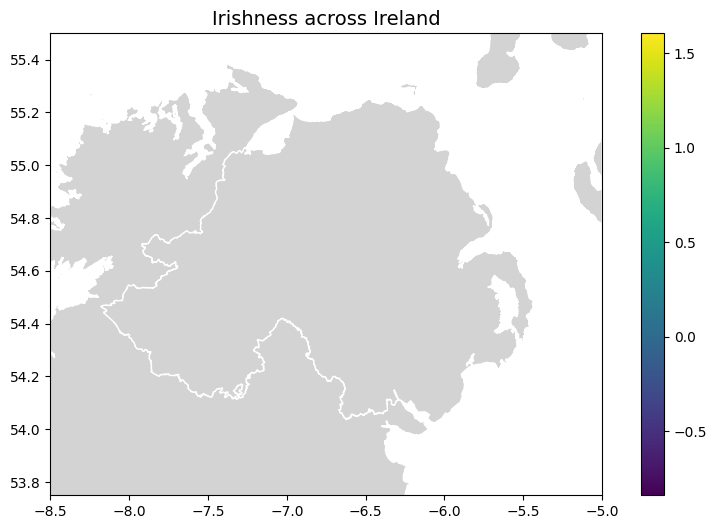

In [27]:
# Create geometry from coordinates
odd_res = res[res['Settlement'].isin(odd_ireland_results)]

geometry = [Point(xy) for xy in zip(odd_res['Longitude'], odd_res['Latitude'])]
gdf = gpd.GeoDataFrame(odd_res, geometry=geometry, crs="EPSG:4326")

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))
british_isles.plot(ax=ax, color="lightgrey", edgecolor="white")

# Points colored by 'irishness'
gdf.plot(
    ax=ax,
    column="irishness",
    cmap="viridis",
    legend=True,
    markersize=40,
    alpha=0.8
)

ax.set_xlim([-8.5, -5])
ax.set_ylim([53.75, 55.5])
ax.set_title("Irishness across Ireland", fontsize=14)

# --- Annotate top 5 towns ---
# for i, row in gdf.head(5).iterrows():
#     ax.annotate(
#         text=row["Settlement"],         # column containing town name
#         xy=(row["Longitude"], row["Latitude"]),
#         xytext=(3, 3),                  # small offset in points
#         textcoords="offset points",
#         fontsize=9,
#         fontweight="bold",
#         color="black"
#         # path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=2, foreground="white")]
#     )

plt.show()
